In [1]:
%%html
<link rel="stylesheet" href="style/style.css">

# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply scenario discovery

1. Generate 10 policies and 1000 scenarios and evaluate them.
2. The experiments array contains the values for each of the 100 decision levers. This might easily mess up the analysis. Remove these columns from the experiment array. *hint: use `experiments.drop`*
3. Apply scenario discovery, focussing on the 10 percent of worst outcomes for reliability


In [2]:
from lakemodel_function import lake_problem

from ema_workbench import Model, RealParameter, ScalarOutcome, SequentialEvaluator, IpyparallelEvaluator, ema_logging, perform_experiments, MultiprocessingEvaluator

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [3]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
n_policies = 10
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, n_policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [4]:
import pandas as pd
experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
data['policy'] = policies

In [5]:
experiments.head()

,b,delta,mean,q,stdev,l0,l1,l10,l11,l12,...,l93,l94,l95,l96,l97,l98,l99,scenario,policy,model
0,0.353649,0.970739,0.039901,3.612804,0.003066,0.038028,0.040433,0.018596,0.011022,0.047575,...,0.023736,0.081705,0.016215,0.02523,0.049247,0.012327,0.031879,0,0,lakeproblem
1,0.205104,0.958915,0.020565,3.414484,0.002559,0.038028,0.040433,0.018596,0.011022,0.047575,...,0.023736,0.081705,0.016215,0.02523,0.049247,0.012327,0.031879,1,0,lakeproblem
2,0.158603,0.987347,0.032086,2.717885,0.001052,0.038028,0.040433,0.018596,0.011022,0.047575,...,0.023736,0.081705,0.016215,0.02523,0.049247,0.012327,0.031879,2,0,lakeproblem
3,0.337415,0.943347,0.033816,2.775585,0.004811,0.038028,0.040433,0.018596,0.011022,0.047575,...,0.023736,0.081705,0.016215,0.02523,0.049247,0.012327,0.031879,3,0,lakeproblem
4,0.143472,0.944227,0.037967,4.379390,0.003277,0.038028,0.040433,0.018596,0.011022,0.047575,...,0.023736,0.081705,0.016215,0.02523,0.049247,0.012327,0.031879,4,0,lakeproblem


In [6]:
exp_cleaned = experiments.drop(experiments.iloc[:, 5:-3], axis=1)
exp_cleaned.head()

,b,delta,mean,q,stdev,scenario,policy,model
0,0.353649,0.970739,0.039901,3.612804,0.003066,0,0,lakeproblem
1,0.205104,0.958915,0.020565,3.414484,0.002559,1,0,lakeproblem
2,0.158603,0.987347,0.032086,2.717885,0.001052,2,0,lakeproblem
3,0.337415,0.943347,0.033816,2.775585,0.004811,3,0,lakeproblem
4,0.143472,0.944227,0.037967,4.379390,0.003277,4,0,lakeproblem


In [7]:
#scenario discovery
from ema_workbench.analysis import prim
import numpy as np

x = exp_cleaned
y = outcomes['reliability'] < np.percentile(outcomes['reliability'], 10)

prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 787 cases of interest
[MainProcess/INFO] mean: 0.8359073359073359, mass: 0.0518, coverage: 0.5501905972045743, density: 0.8359073359073359 restricted_dimensions: 6


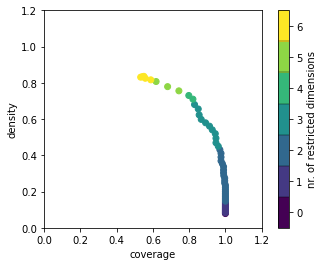

In [8]:
import matplotlib.pyplot as plt
box1.show_tradeoff()
plt.show()

<div class="analysis">
The graph shows tradeoff between coverage of each box of the peeling trajectory (how many points of interest are within the PRIM box) and density (ratio between points of interest and points not of interest).
   
When 0-1 dimension is restricted (blue) there is high coverage, but very low density (max 0.2).
    
When 2-3 dimensions are restricted (green) density increase with slow relative decrease in coverage.
    
When 5 dimensions are restricted (yellow) there is greater relative improvement in density for smaller losses in coverages.
</div>

coverage           1
density     0.222946
id                20
mass           0.353
mean        0.222946
res_dim            2
Name: 20, dtype: object

     box 20                                         
        min       max                      qp values
b  0.100084  0.297680   [-1.0, 1.13536689708058e-55]
q  2.001404  3.547471  [-1.0, 4.027648567142531e-41]



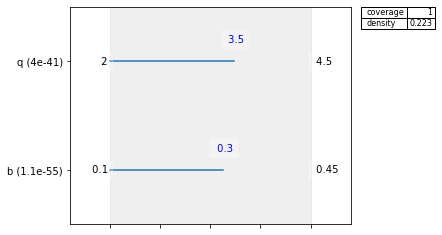

In [9]:
#inspect the 20th box
box1.inspect(20)
box1.inspect(20, style='graph')
plt.show()

<div class="analysis">
We opted to inspect candidate box 20 from the peeling trajectory due to its high coverage and fewer restricted parameters. Quasi p-values indicate that variation in output is statistically significant by modifying the variable in question.
</div>

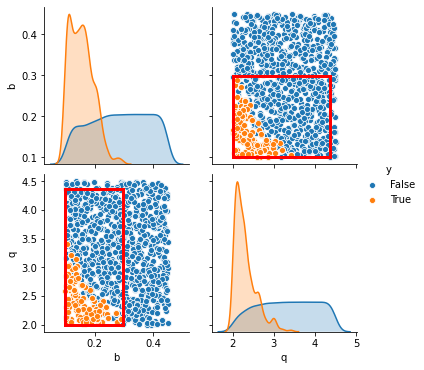

In [10]:
box1.show_pairs_scatter(12)
plt.show()

<div class="analysis">
Above we inspect the 12th candidate box (which only uses 2 dimensions). True indicates points at which reliability exceedes the threshold and leads to irrevesible eutrophication. We observe that these generally occur when both b and q are low. These refer to the lake's natural removal and recycling rate respectively, which if both low would quickly lead to accumulation of pollutants and lowering reliability.
    
The 12th candidate box has a coverage of 1 and a density of 0.15 (as shown in the tradeoff figure), meaning that it's not really a good box, as there is still a lot of noise in the box (points of no interest).
</div>

## Visualize the results using Dimensional Stacking
Take the classification of outcomes as used in step 3 of scenario discovery, and instead visualize the results using dimensional stacking. How do these results compare to the insights from scenario discovery?

[MainProcess/INFO] model dropped from analysis because only a single category


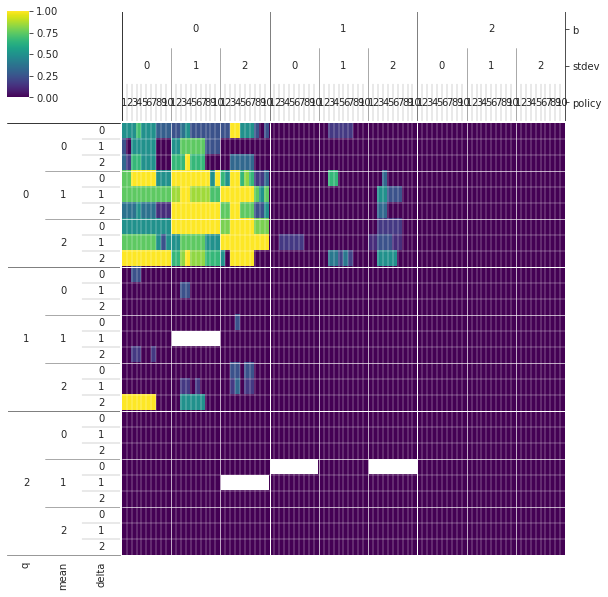

In [11]:
from ema_workbench.analysis import dimensional_stacking

x = exp_cleaned
y = outcomes['reliability'] < np.percentile(outcomes['reliability'], 10)
dimensional_stacking.create_pivot_plot(x,y, 3)
plt.show()

<div class="analysis">
Dimensional stacking of the variables shows that while both b and q are low, there is a higher proportion of outcomes with low reliability of lake water quality. This relationship is intensified under conditions with higher mean natural inflows. This is consistent with previous assessments.
</div>